# What is a tweet's weight?

In [17]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

## Importing the dataset

For the next task, we will use the condensed datasets, one for each year, starting with 2009 until 2017. The last tweet is written on November 24th, 2017. 

In [6]:
FILES_FOLDER = os.path.join('.', 'Trump_tweets')

In [12]:
datasets_list = []

for year in range(2009, 2018):
    CURRENT_FILE = os.path.join(FILES_FOLDER, 'condensed_' + str(year) + '.json')
    
    current_dataset = pd.read_json(CURRENT_FILE)
    datasets_list.append(current_dataset)
    
condensed_dataset = pd.concat(datasets_list) # concatenate the yearly datasets
condensed_dataset = condensed_dataset.drop(['in_reply_to_user_id_str', 'is_retweet', 'id_str'], axis=1) # drop the three columns
condensed_dataset = condensed_dataset.set_index('created_at', drop=True) # reindex data by Twitter index
condensed_dataset = condensed_dataset.sort_index() # sort the big dataset on the date of Tweets

In [13]:
condensed_dataset.head()

,favorite_count,retweet_count,source,text
created_at,,,,
2009-05-04 18:54:25,202,253,Twitter Web Client,Be sure to tune in and watch Donald Trump on L...
2009-05-05 01:00:10,3,2,Twitter Web Client,Donald Trump will be appearing on The View tom...
2009-05-08 13:38:08,2,3,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...
2009-05-08 20:40:15,27,8,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...
2009-05-12 14:07:28,1950,1421,Twitter Web Client,"""My persona will never be that of a wallflower..."


As we can observe, the columns available can give a lot of insight, with:

* **created_at**: the exact second of posting Tweet
* **favorite_count**: the number of *favorites* the tweet got
* **retweet_count**: the number of *retweets* the tweet got
* **text**: the actual tweet text
* **source**: the client used for posting the tweet, which can be Twitter Web Client, Twitter for Android or iPhone and so on.

We decided to drop the columns *in_reply_to_user_id_str*, *is_retweet* and *id_str* for the start, as we think it cannot give us information for the tasks we want to perform.

# Are Trump's tweets getting more rude over time?

One of the first research questions we ask is if the tweets are getting more rude or maybe less rude over time, and especially after Trump became a presidential candidate. We know that while he was a running for presidency, he used a lot of negative words against his opponents, especially Hillary Clinton:

<img src="crooked_hilary.png">

Also, after becoming president, he posted some very acid tweets, as we can see below:

<img src="kim.png">

We want to stress out a very important aspect of this analysis. For other types of media, like newspapers or TV, there exists a reporter and an editorial board, who decide exactly what gets published and what not, and also the meaning of the words might get interpreted in a different way than intended. Therefore, an analysis in such a context would require further investigations, because it might be the case that the media tries to use a more acid language just to increase the rating.

However, this is not the case for Twitter, where the person decides exactly what to post, and also the language. Therefore, an overall increase or decrease in the number of rude words is directly related to the person posting the tweets, without involving other third parties that might filter the information.

---

Therefore, for realizing this task, we thought to use different approaches, such as analysis of the *usage of words with negative impact*, *sentiment analysis* on the tweets and then using *emotions associated to different words*, to be able to expand the sphere of action from a two-class result (*positive* vs *negative* sentiment) to a broader class result, associated with *emotions*.

For this, we need to process the tweets, and that involves Natural Language Processing (NLP) techniques.

## A little bit of NLP never hurts

For basic NLP tasks such as *word tokenization*, *Part of Speech (POS) tagging* and *lemmatization*, we will use a Python library called nltk - *Natural Language ToolKit*. We decided to download all the corpuses available, so installation of the library is pretty straightforward, with this commands in the Command Line:

* conda install nltk
* python -m nltk.downloader all

Then, we can import nltk library:

In [18]:
import nltk

### Initial tweet processing

The basic NLP pipeline would follow like this:
* First , we want to *extract the hashtags* from the tweet for further analysis
* Then, *delete links, retweet handles and special characters* such as &amp;
* After that, *remove stop words*, using a predefined list of stop words in the nltk corpus and also a handcrafted list
* Finally, delete punctuation signs from tweet.

The result of the processing pipeline would be a list of words, every one of them being meaningful, which can then be given to the next layer of processing.


---

The function that extracts the hashtags is defined below:

In [22]:
import re # import re package for regex manipulation

In [23]:
def extract_hashtags(tweet):
    '''Function that extracts the hashtags from a tweet'''
    
    hashtags = [hashtag[:-1] for hashtag in re.findall('#[^\s]+\s', tweet)]
    return hashtags

The function that removes unwanted parts of tweet is defined in the next cell:

In [24]:
def remove_unwanted(tweet):
    '''Function that simply removes unwanted parts of tweet, such as links, retweet handles and weird characters.'''
    
    to_delete = ['&amp;', 'RT @[a-zA-Z0-9 ]+:', ' @[a-zA-Z0-9 ]+:',
                 '(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?']
    tweet_processed = tweet
    
    for expression in to_delete:
        tweet_processed = re.sub(expression, '', tweet_processed)
        
    return tweet_processed

Next, we need to remove the stopwords in the tweet, i.e. words that only make the link between the important words, e.g. *for*, *and* and so on. Usually, the stop words bear no semantic significance, so we can actually reemove them from our list. A good corpus with stopwords for English language is present in nltk package:

In [25]:
from nltk.corpus import stopwords

We can now write the function that removes the stopwords from the list:

In [34]:
def remove_stop_words(words):
    '''Function that removes the stopwords from the words list.'''
    
    extra_list = ["'s", "n't", ]
    
    filter_function = lambda x: (x.lower() not in extra_list) and (x.lower() not in (stopwords.words('english'))) 
    # the filtering function, i.e. only takes into consideration words that are not in stopword corpus or hand-crafted list
    # considers only lower-case words, but outputs the words as they were initially written.
    
    processed = list(filter(filter_function, words))
    return processed

Last point of the pipeline, we delete the punctuation marks in the tweet:

In [28]:
def delete_punctuations(words):
    '''Function that deletes the punctuation marks in the list of words.'''
    
    punctuation_marks = [".", "?", "!", ":", ";", "-", "(", ")", "[", "]", "...", "\"", ",",'“', '"', "'", "”", '``', "''", '@', '#', "’", '&']
    
    return list(filter(lambda x: x not in punctuation_marks, words))

Finally, we can use all the previous defined functions, so that we create the basic NLP processing function for a single tweet. The function returns the list of meaningful words in the tweet, in the exact initial form, i.e. not lower-cased. Also, it returns the list of used hashtags, that might be useful for future processing:

In [29]:
def process_tweet(tweet):
    '''Function that processes the tweet, as specified above.'''
    
    hashtags = extract_hashtags(tweet) # extracts hashtags
    tweet = remove_unwanted(tweet) # remove unwanted parts
    words = nltk.word_tokenize(tweet) # tokenize tweet into words
    no_stop_words = remove_stop_words(words) # remove stopwords
    no_punctuation = delete_punctuations(no_stop_words) # delete punctuation marks
    
    return no_punctuation, hashtags

Let's see how our function works on a real tweet:

In [42]:
print(condensed_dataset.iloc[2017].text)
print(process_tweet(condensed_dataset.iloc[2017].text))

Welcome to the new reality. Goldman Sachs just based their new Asia Pacific chairman not in Tokyo, but Beijing.  http://t.co/wNWdZjTE
(['Welcome', 'new', 'reality', 'Goldman', 'Sachs', 'based', 'new', 'Asia', 'Pacific', 'chairman', 'Tokyo', 'Beijing'], [])


We can say that the function does exactly what we intended, so we can move on to the next parts.

### Counting negative words

The first research idea is to see the trend of the negative words in tweets. We used a corpus of almost 4800 words with negative impact, which can be found at [the GitHub page](https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/blob/master/data/opinion-lexicon-English/negative-words.txt), and also was used in the paper:

Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews.", Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, Washington, USA.

In [43]:
with open(os.path.join('.', 'negative_words.txt')) as f:
    negative_words = set(map(str.strip, f.readlines()))   

Next, we might want to assess how many negative words a tweet has, which we can do using the next function:

In [46]:
def count_negative_words_in_tweet(tweet):
    '''Function that counts how many negative words are contained in the negative dataset.'''
    
    tweet_words_processed = set(process_tweet(tweet)[0]) # create a set of the meaningful words in the tweet
    return len(tweet_words_processed.intersection(negative_words)) # return the number of negative words in the tweet

Finally, we can create a new column in the dataset, which represents how many negative words the tweet contains:

In [47]:
condensed_dataset['negative_words'] = condensed_dataset.text.apply(count_negative_words_in_tweet)

In [48]:
condensed_dataset_dataseted_dataset[2000:2005]

,favorite_count,retweet_count,source,text,negative_words
created_at,,,,,
2012-06-09 22:38:36,21,58,Twitter Web Client,Miss Florida was great in her denial of Miss P...,1
2012-06-11 16:27:10,39,360,Twitter Web Client,.@MannyPacquiao was robbed in his title fight ...,1
2012-06-11 16:41:37,18,64,Twitter Web Client,With almost 1.3 million followers and rising r...,1
2012-06-11 17:10:13,31,107,Twitter Web Client,"""Donald Trump"" song is up to almost 60 million...",1
2012-06-11 17:34:01,11,71,Twitter Web Client,Last Friday's gaffe by @BarackObama claiming t...,1


Having this information, we might want to plot the average number of negative words used each two months, which we will do below:

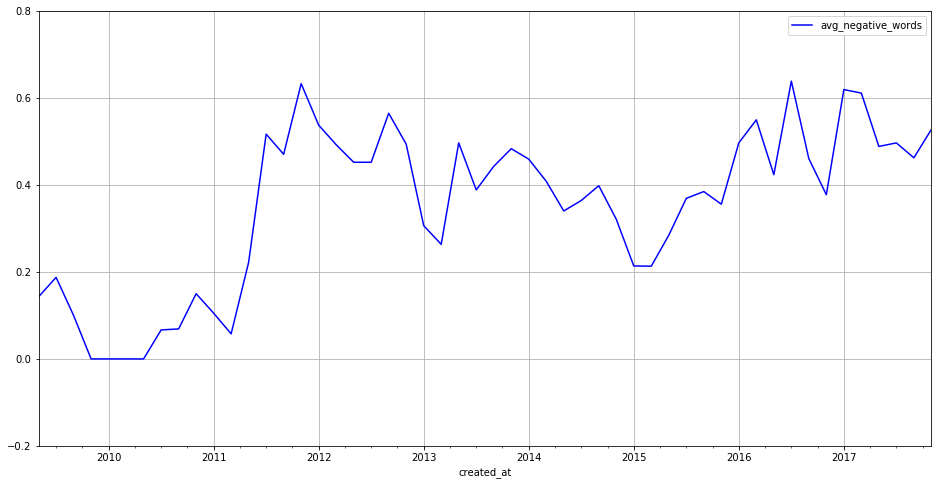

In [67]:
monthly_negative_words = condensed_dataset['negative_words'].groupby(pd.TimeGrouper(freq='2M')).mean()
monthly_negative_words.plot(grid=True, label='avg_negative_words', color='blue', ylim=(-0.2, 0.8), figsize =(16,8))
plt.legend(loc='upper right')

We can see that the number of bad words used was really low in the first two years, then followed by a sudden increase in 2011,  a continuous decrease until mid-2015 and then again a continuous increase starting with mid-2015 until 2017. Knowing that he announced his presidential candidacy in June 2015, we might correlate his increase in negative words with his fight for the presidency and then maybe for his tries to prove he is a "strong" leader. 

---

We feel like this point of view should be investigated more closely, with a wider dataset or maybe on some different sub-datasets, which will be presented in a next section.

### Performing tweets sentiment analysis

Next idea would be to consider a sentiment analysis classifier, to analyze the sentiment of each tweet and then look for major changes in the sentiment of the tweets as a time-series.

For sentiment analysis we decided to use a classifier in the nltk package, namely **VADER**. As presented [in this link](http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html), VADER assigns a sentiment score for each word, realized using crowd-sourcing on *Amazon Mechanical Turk*. In a nutshell, VADER looks not only at scores for words, but also at capitalisation of letters and expressions such as **extremely** bad, which should increase the negativity of the score, in this case. Also, this is one of the main reasons we decided to keep text exactly as it was initially and not change letters to lower. More information could be found in the initial [paper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf). 

A thing that should be mentioned is that this method does not use Machine Learning techniques for classification, therefore we might want to look more into further methods. Therefore, we first create an instance of the sentiment analyzer:

In [56]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

Then, we would want to create a new column, where we could keep the sentiment for each tweet. For that, we can use the following method: 

In [57]:
condensed_dataset['sentiment'] = condensed_dataset.text.map(lambda x: sid.polarity_scores(x)['compound'])

Then, a plot of the average sentiment every two months is realized below:

In [ ]:
monthly_sentiment = condensed_dataset['sentiment'].groupby(pd.TimeGrouper(freq='2M')).mean()
monthly_sentiment.plot(grid=True, label='avg_sentiment', color='blue', ylim=(-0.2, 0.8), figsize =(16,8))
plt.legend(loc='upper right')

We can see that the current plot can be interpreted exactly as the one before, where we could see a decrease in positivity between 2011 and 2012, then an increase until 2015 and then again a decrease. Again, the signal is not very strong, but there might be imbalanced features present, and after balancing them we might actually get some good results.

---

Also, for a good result using ML techniques, we might use [*Google Sentiment Analysis Tool*](https://cloud.google.com/natural-language/docs/sentiment-tutorial), which will be tried for the next milestone, supposing that the Google product is one reference classifier for sentiment analysis. 

### Using words emotion valence

The third tried method is to move from sentiment analysis, which has only two outputs (positive or negative), to emotions, which have a bigger number of outputs. Therefore, we could use words emotions valence, i.e. scores assigned to a list of words, for how likely it is that each word has a specific emotion. For that, we could use the [**Depeche Mood**](https://github.com/marcoguerini/DepecheMood/releases) dataset, which has over 37K words associated with emotions scores, for each one of this emotions:
* AFRAID
* AMUSED
* ANGRY
* ANNOYED
* DONT_CARE
* HAPPY
* INSPIRED
* SAD

We import the dataset below and take a short look at some random 10 entries:

In [69]:
EMOTIONS_FILE = os.path.join('.', 'DepecheMood_V1.0', 'DepecheMood_tfidf.txt')

emotions_df = pd.read_csv(EMOTIONS_FILE, sep='\t')
emotions_df[2000:2010]

,Lemma#PoS,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
2000,asphalt#v,0.000000,0.455288,0.000000,0.233177,0.218037,0.000000,0.000000,0.093499
2001,asphyxia#n,0.000000,0.000000,0.214225,0.368184,0.000000,0.000000,0.000000,0.417591
2002,asphyxiate#v,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000
2003,asphyxiation#n,0.039041,0.000000,0.238446,0.026706,0.034577,0.000000,0.000000,0.661231
2004,aspirant#n,0.073484,0.147461,0.171933,0.238579,0.148417,0.108419,0.054856,0.056852
2005,aspiration#n,0.149646,0.108822,0.070699,0.124269,0.145628,0.125095,0.179783,0.096058
2006,aspire#v,0.108132,0.133935,0.075823,0.131043,0.129200,0.114679,0.225105,0.082085
2007,aspirin#n,0.079129,0.237204,0.185007,0.050172,0.130326,0.134831,0.009180,0.174151
2008,aspiring#a,0.066070,0.083700,0.123111,0.167108,0.175827,0.111036,0.168852,0.104297
2009,ass#n,0.090754,0.253146,0.158853,0.123856,0.124280,0.066958,0.123809,0.058344


We can see that besides the word, we will need to have the associated Part of Speech, and also the word is represented by a root, and not a derived form (such as *aspirations* for *aspiration*), for example. Therefore, we might want to change the processing function of a tweet, written at first point, to also include the Part of Speech of each word, and also to extract the root of the word, process called *lemmatization*. This is all done below, in the exact same manner as for the previous task:

In [71]:
def remove_stop_words_pos(words_pos):
    '''Function that removes the stopwords from the given list. The list has the form [(word, pos)], as opposed to the first
    case, where it was only [word].'''
    
    extra_list = ["'s", "n't"]

    filter_function = lambda x: (x[0] not in extra_list) and (x[0] not in (stopwords.words('english'))) 
    # the filtering function, i.e. only takes into consideration words that are not in stopword corpus or hand-crafted list
    # note that only the words are taken into consideration, and words are on the first position of the pair.
    
    processed = list(filter(filter_function, words_pos))
    return processed

In [72]:
def delete_punctuations_pos(words):
    '''Function that removes the punctuation marks from the given list, which has the format [(word, pos)].'''
    
    punctuation_marks = [".", "?", "!", ":", ";", "-", "(", ")", "[", "]", "...", "\"", ",",'“', '"', "'", "”", '``', "''", '@', '#', "’", '&']
    return list(filter(lambda x: x[0] not in punctuation_marks, words))

For lemmatization and POS tagging, we will use also nltk corpuses, as defined below:

In [74]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

The wordnet lemmatizer has different POS tags than the nltk ones, so we need a function to convert between the two:

In [75]:
def get_wordnet_pos(treebank_tag):
    '''Function that transforms nltk tag to wordnet tag'''
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

Also, the Depeche Mood library uses different POS tags, and we need to transform between the nltk ones and Depeche Mood ones:

In [77]:
def get_depeche_mood_pos(treebank_pos):
    '''Function that transforms nltk tag to Depeche Mood tag.'''
    
    if treebank_pos.startswith('J'):
        return 'a' # adjective is a in Depeche Mood, compared to J in nltk.
    return treebank_pos[0].lower()

Next, we know that the words in Depeche Mood are in the form *lemmatized#POS*, so we write a function that constructs this format:

In [79]:
def lemmatize_and_join(word, pos):
    '''Function that lemmatizes a word, and then returns a word in the format lemmatized#POS, as required by the Depeche Mood 
    dataset. Note that the POS given as parameter is one in the nltk library, not Depeche Mood or WordNet.'''
    
    pos_wordnet = get_wordnet_pos(pos)
    
    if pos_wordnet == '':
        return None # not a part of speech
    
    lemmatized = lemmatizer.lemmatize(word, pos_wordnet)
    pos_depeche_mood = get_depeche_mood_pos(pos)
    
    return lemmatized + "#" + pos_depeche_mood

Now we are ready to write the new processing function, which will return the list of words, but in the special format used by the Depeche Mood dataset:

In [80]:
def process_tweet_pos(tweet):
    '''Function that processes a tweet as in previous case, but also appending the POS and lemmatizing the word'''
    
    tweet = tweet.lower() # convert everything to lower-case
    
    tweet = remove_unwanted(tweet) # remove links and other unwanted parts of tweet
    words = nltk.word_tokenize(tweet) # tokenize tweet into words
    words_pos = nltk.pos_tag(words) # realize the POS-tagging of the tweet
    
    no_stop_words = remove_stop_words_pos(words_pos) # remove the stopwords
    no_punctuation = delete_punctuations_pos(no_stop_words) # remove the punctuation marks
    
    words_unfiltered = [lemmatize_and_join(word, pos) for word, pos in no_punctuation] # construct the list of lemmatized words
    words_final = list(filter(lambda x: x is not None, words_unfiltered)) # remove the Nones from the final list
    
    return words_final

Next, having this function, we might want to compute an emotion score for each tweet. For that, we will compute an emotion score for each word in the tweet, and the score of the entire tweet will be represented by the sum of the scores of each word. We will write the function that realizes the tweet scores modularily, using helper-functions. First, we write a function that initializes the scores for each emotion to 0: 

In [81]:
def initialize_scores():
    '''Function that initializes the score for each emotion to 0.'''
    
    score_dict = {}
    
    for emotion in emotions_df.columns[1:]:
        score_dict[emotion] = 0
        
    return score_dict

Then, we need a function that, given a specific word that exists in the Depeche Mood dataset and the current scores for each emotion as a dictionary, updates the scores for each emotion by realizing the sum with the new scores:

In [82]:
def update_scores(word_pos, score_dict):
    '''Function that updates the emotion scores with the values associated with the given word.'''
    
    word_emotions_scores = dict(emotions_df[emotions_df['Lemma#PoS'] == word_pos].iloc[0])
    del word_emotions_scores['Lemma#PoS']
    
    for emotion, score in word_emotions_scores.items():
        score_dict[emotion] += score

Finally, we might write the function that computes the emotion scores for the tweet:

In [83]:
def get_tweet_scores(tweet):
    '''Function that computes the tweet emotion scores for the given tweet.'''
    
    score_dict = initialize_scores() # initialize the scores to 0
    emotions_words = set(emotions_df['Lemma#PoS']) 
    
    words_filtered_pos = process_tweet_pos(tweet) # process the tweet as written above
    
    for word_pos in words_filtered_pos:
        if word_pos not in emotions_words: # pass over the words which are not in Depeche Mood dataset
            continue
            
        update_scores(word_pos, score_dict) # update the scores for each emotion according to the scores of the current word
    
    return score_dict

Having the function that computes the emotion scores for each tweet as the sum of the emotion scores for each individual word, we can now include all those scores as new columns in the dataset. Therefore, we do it below:

In [85]:
condensed_final = condensed_dataset.copy()
emotions = set(emotions_df.columns) - {'Lemma#PoS'} # all the emotions in the dataset

emotions_dict = {emotion : [] for emotion in emotions} # for each emotion, construct the list of tweet scores, in order
    
for tweet in condensed_final.text:
    scores = get_tweet_scores(tweet) # compute the emotion scores, for each emotion
    
    for emotion, score in scores.items():
        emotions_dict[emotion].append(score)
        
for emotion_name, emotion_values in emotions_dict.items():
    new_column = pd.Series(emotion_values, index=condensed_final.index) # create the new column with the index of dataframe
    condensed_final[emotion_name] = new_column # add new column to dataframe

In [86]:
condensed_final.head()

,favorite_count,retweet_count,source,text,negative_words,sentiment,AFRAID,AMUSED,ANGRY,ANNOYED,SAD,HAPPY,DONT_CARE,INSPIRED
created_at,,,,,,,,,,,,,,
2009-05-04 18:54:25,202,253,Twitter Web Client,Be sure to tune in and watch Donald Trump on L...,0,0.5255,0.992164,1.702892,1.311094,1.409545,1.153361,1.352038,1.637963,1.440944
2009-05-05 01:00:10,3,2,Twitter Web Client,Donald Trump will be appearing on The View tom...,0,0.7712,1.057917,1.848110,1.103627,1.528575,1.340874,1.446139,2.017966,1.656793
2009-05-08 13:38:08,2,3,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...,1,0.6468,1.006678,1.632097,1.134400,1.216011,1.004224,1.196502,1.551681,1.258408
2009-05-08 20:40:15,27,8,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...,0,0.0000,0.740472,1.407248,0.710885,1.067461,0.992012,1.279288,1.308805,1.493830
2009-05-12 14:07:28,1950,1421,Twitter Web Client,"""My persona will never be that of a wallflower...",0,0.0000,0.631105,1.087715,0.680554,0.965473,0.785413,0.839137,0.941357,1.069245


Next, we want to plot the results of the above computations, aggregated per two months:

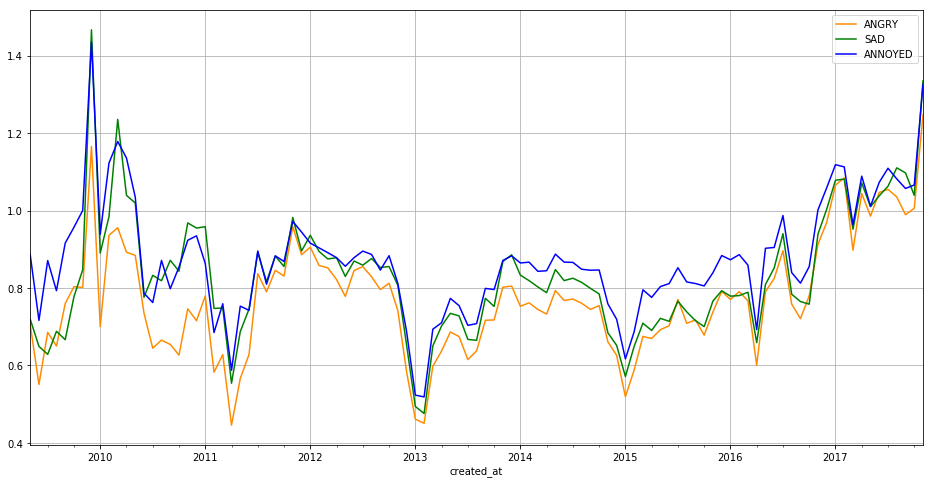

In [87]:
emotions = ['ANGRY', 'SAD', 'ANNOYED']
colors = ['darkorange', 'green', 'blue']

for emotion, color in zip(emotions, colors):
    aggregate = condensed_final[emotion].groupby(pd.TimeGrouper(freq='1M')).mean()
    aggregate.plot(grid=True, label=emotion, color=color, figsize =(16,8))
    
plt.legend(loc='upper right')